# Voice Recognition
Using a triplet loss model trained in Attempt 1.1, finetune on specific set of voices.

## Imports & Setup

In [1]:
import time
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import h5py
from tensorflow.keras.optimizers import (
    Adam
)
from tensorflow.keras.layers import (
    Layer, Input
)
import ctypes
GetKeyState = ctypes.windll.user32.GetKeyState
from paiutils.neural_network import Trainer, Predictor
from paiutils import audio
from paiutils.analytics import Analyzer
from paiutils.util_funcs import load_directory_database, save_directory_database
pyaudio = audio.pyaudio

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


C:\Users\Travis\Anaconda3\envs\AIGPU\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.6.0-dev20210413). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Create Finetune data

In [3]:
pyaudio = audio.pyaudio

def record_until_key(rate=16000, key=0x11):
    p = pyaudio.PyAudio()
    patype = pyaudio.paInt16
    stream = p.open(format=patype,
                    channels=1,
                    rate=rate,
                    input=True,
                    frames_per_buffer=400)
    frames = []
    while True:
        frames.append(np.frombuffer(stream.read(4000), dtype='int16') / np.iinfo('int16').max)
        if GetKeyState(key) > 1:
            break
    stream.stop_stream()
    stream.close()
    p.terminate()
    return np.concatenate(frames), rate

In [4]:
metadata = pd.read_csv('D:\\cv_mutated\\metadata.tsv', delimiter='\t')
sentences = metadata['sentence'].value_counts()[:100]

In [6]:
num_mutations = 5
class_size = (num_mutations + 1) * 50
length = 3
sample_rate = 16000

backgrounds = []
for file in os.listdir('D:\\cv_mutated\\background'):
    x, sr, at = audio.load(f'D:\\cv_mutated\\background\\{file}', rate=sample_rate)
    backgrounds += np.array_split(x, np.arange(0, len(x), sample_rate * length)[1:])[:-1]
for path in metadata['path'].sample(5000):
    x, sr, at = audio.load(f'D:\\cv_data\\{path}', rate=sample_rate)
    x = np.roll(x, int(len(x) * np.random.random()))
    x = audio.set_duration(x, sample_rate, length)
    backgrounds.append(x)
backgrounds = np.array(backgrounds, dtype=np.float32)

In [7]:
lens = []
xs = np.empty((class_size, sample_rate * length), dtype=np.float32)
group_id = 0
while True:
    ndx = 0
    print('\n' + str(ndx))
    for sentence in sentences.sample(50).index:
        input(sentence)
        x, sr = record_until_key()
        x = audio.vad_trim_sides(x, sr, .03, 3)
        x = audio.vad_trim_all(x, sr, .03, 1)
        audio.play(x, sample_rate)
        lens.append(audio.calc_duration(x, sample_rate))
        xs[ndx] = audio.set_duration(x, sample_rate, length)
        ndx += 1
        for _ in range(num_mutations):
            m = np.random.random()
            #print(m)
            y = np.roll(x, int(len(x) * m))
            y = audio.set_duration(y, sample_rate, length)
            #y = x.copy()
            m = np.random.uniform(.25, 1.75)
            if m > 1:
                m = 1 / (2 - m)
            #print(m)
            y = audio.adjust_volume(y, m)
            m = np.maximum(np.random.uniform(-.2, .2), 0)
            #print(m)
            ym = y[y > 0].mean()
            y += np.random.uniform(low=-ym, high=ym, size=len(y)) * m
            if np.random.random() > .25:
                m = np.random.uniform(.1, .5)
                m1 = np.random.randint(len(backgrounds))
                #print(m, m1)
                y += audio.set_power(backgrounds[m1], audio.calc_rms(y) * m)
            y = np.clip(y, -1, 1)
            m = np.random.uniform(.95, 1.05)
            #print(m)
            y = audio.adjust_speed(y, sample_rate, m)
            y = audio.set_duration(y, sample_rate, length)
            #audio.play(backgrounds[m1], sample_rate)
            #audio.play(y, sample_rate)
            xs[ndx] = y
            ndx += 1
    with h5py.File(f'D:\\cv_mutated\\finetune\\{group_id}.h5', 'w') as file:
        file.create_dataset('data', data=xs)
    group_id += 1
np.array(lens).mean()

There were raised voices,and some sort of struggle appeared to be going on. .
I heard a peculiar humming sound from the pit.
Hundreds of observers saw the flame that night and the night after.
There were really, I think, two or three hundred people elbowing one another.
I was disappointed at this inanimate bulk.
Its lower end was still embedded.
It would have been visible to me, had I only looked up as it passed.
Of course, the two were unable to do anything.
A line of flame high can be seen in the atmosphere.
When he saw Henderson in his garden, he called over the fence and made himself understood.
The only shadow was that of the few scattered pine trees.
I'm trying to explain to my mother how to get pictures off her phone.
The shop folks were taking down their shutters, and people were opening their bedroom windows.
About eleven, I walked back to my home in Maybury because nothing seemed to be happening.
And at that I told him, and he took my place.
Something inside the cylinder was 

KeyboardInterrupt: Interrupted by user

## Load Data

Load metadata and split into train and validation

In [3]:
sample_rate = 16000
length = 3
num_mutations = 5
class_size = (num_mutations + 1) * 50
metadata = pd.read_csv('D:\\cv_mutated\\metadata.tsv', delimiter='\t')
del metadata['Unnamed: 0']
train_metadata = pd.read_csv('D:\\cv_mutated\\train_metadata.tsv', sep='\t').sample(4000)
vali_metadata = pd.read_csv('D:\\cv_mutated\\vali_metadata.tsv', sep='\t')

In [4]:
#ids = pd.Series(train_metadata['client_id'].unique()).sample(100)
#ids = train_metadata['client_id'].isin(ids)
#finetune_train_metadata = train_metadata[ids]
#train_metadata = train_metadata[~ids]

Set nids for metadata

In [5]:
train_labels = train_metadata['client_id'].unique()
train_metadata['client_nid'] = train_metadata['client_id'].replace(train_labels, np.arange(len(train_labels)))

In [6]:
vali_labels = vali_metadata['client_id'].unique()
vali_metadata['client_nid'] = vali_metadata['client_id'].replace(vali_labels, np.arange(len(vali_labels)))

In [7]:
#finetune_train_labels = finetune_train_metadata['client_id'].unique()
#finetune_train_metadata['client_nid'] = finetune_train_metadata['client_id'].replace(finetune_train_labels, np.arange(len(finetune_train_labels)))

Load data

In [8]:
train_anchors = np.empty((len(train_metadata['client_id'].unique()), 50, sample_rate * length), dtype=np.float32)
for group_id, data in train_metadata[['client_id', 'client_nid', 'path']].groupby('client_id'):
    with h5py.File(f'D:\\cv_mutated\\{group_id}.h5', 'r') as hf:
        train_anchors[int(data['client_nid'].values[0])] = hf['data'][:]

In [9]:
vali_anchors = np.empty((len(vali_metadata['client_id'].unique()), 50, sample_rate * length), dtype=np.float32)
for group_id, data in vali_metadata[['client_id', 'client_nid', 'path']].groupby('client_id'):
    with h5py.File(f'D:\\cv_mutated\\{group_id}.h5', 'r') as hf:
        vali_anchors[int(data['client_nid'].values[0])] = hf['data'][:]

In [10]:
#finetune_train_anchors = np.empty((len(finetune_train_metadata['client_id'].unique()), class_size, sample_rate * length), dtype=np.float32)
#for group_id, data in finetune_train_metadata[['client_id', 'client_nid', 'path']].groupby('client_id'):
#    with h5py.File(f'D:\\cv_mutated\\{group_id}.h5', 'r') as hf:
#        finetune_train_anchors[int(data['client_nid'].values[0])] = hf['data'][:]

In [11]:
group_ids = os.listdir('D:\\cv_mutated\\finetune')
finetune_train_anchors = np.empty((len(group_ids), class_size, sample_rate * length), dtype=np.float32)
for group_id  in group_ids:
    with h5py.File(f'D:\\cv_mutated\\finetune\\{group_id}', 'r') as hf:
        finetune_train_anchors[int(group_id.split('.')[0])] = hf['data'][:]

(1, 48000)

In [12]:
train_anchors.nbytes / 1000000000, vali_anchors.nbytes / 1000000000, finetune_train_anchors.nbytes / 1000000000

(30.2784, 0.96, 0.0576)

In [13]:
train_anchors = np.expand_dims(train_anchors, axis=-1)

In [14]:
vali_anchors = np.expand_dims(vali_anchors, axis=-1)

In [15]:
finetune_train_anchors = np.expand_dims(finetune_train_anchors, axis=-1)

## Model

In [16]:
x0 = keras.layers.Input(shape=train_anchors.shape[2:])
x = keras.layers.Conv1D(32, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same', trainable=False)(x0)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(32, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same', trainable=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(32, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same', trainable=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(32, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same', trainable=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(64, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same', trainable=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(64, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same', trainable=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(64, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same', trainable=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(64, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same', trainable=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(128, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same', trainable=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(128, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same', trainable=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(128, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same', trainable=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(128, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x)
x = keras.layers.Dropout(0.1)(x)
#x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Flatten()(x)
dense_layer = keras.layers.Dense(128, activation=None, kernel_initializer='he_normal')(x)
norm_layer = keras.layers.Lambda(lambda  x: tf.math.l2_normalize(x, axis=1))(dense_layer)
model = keras.Model(inputs=x0, outputs=norm_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48000, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24000, 32)         128       
_________________________________________________________________
dropout (Dropout)            (None, 24000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12000, 32)         3104      
_________________________________________________________________
dropout_1 (Dropout)          (None, 12000, 32)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6000, 32)          3104      
_________________________________________________________________
dropout_2 (Dropout)          (None, 6000, 32)          0     

### Train

In [17]:
def split_triplet_generator(anchors, negative_anchors, batch_size):
    while True:
        a_ndxs = np.random.choice(np.arange(len(anchors)), size=batch_size)
        a_ndxs2 = np.random.choice(np.arange(len(anchors[0])), size=batch_size)
        a_batch = anchors[a_ndxs, a_ndxs2]
        
        p_ndxs = np.random.choice(np.arange(len(anchors[0])), size=batch_size)
        p_batch = anchors[a_ndxs, p_ndxs]
        
        p2_ndxs = np.random.choice(np.arange(len(anchors[0])), size=batch_size)
        p2_batch = anchors[a_ndxs, p2_ndxs]
        
        #n_ndxs = np.random.choice(np.arange(len(anchors)) - 1, size=batch_size)
        #n_ndxs[n_ndxs >= a_ndxs] += 1
        #n_ndxs2 = np.random.choice(np.arange(len(anchors[0])), size=batch_size)
        #n_batch = anchors[n_ndxs, n_ndxs2]
        
        n2_ndxs = np.random.choice(np.arange(len(negative_anchors)), size=batch_size)
        n2_ndxs2 = np.random.choice(np.arange(len(negative_anchors[0])), size=batch_size)
        n2_batch = negative_anchors[n2_ndxs, n2_ndxs2]
        n2_ndxs += len(anchors)

        #len(anchors) > 1:
        #ndxs = np.hstack([a_ndxs, a_ndxs, n_ndxs, n2_ndxs])
        #batch = np.vstack([a_batch, p_batch, n_batch, n2_batch])
        ndxs = np.hstack([a_ndxs, a_ndxs, n2_ndxs])
        batch = np.vstack([a_batch, p_batch, n2_batch])
        yield batch, ndxs

In [18]:
def paccuracy(y_true, y_pred):
    batch_size = len(y_true) // 3
    anchors = y_pred[:batch_size, :]
    postives = y_pred[batch_size:batch_size * 2, :]
    
    a = tf.norm(postives - anchors, axis=-1)
    a = tf.reduce_sum(tf.cast(a < 1.0, tf.int32), axis=-1)
    
    return a / batch_size

def naccuracy(y_true, y_pred):
    batch_size = len(y_true) // 3
    anchors = y_pred[:batch_size, :]
    postives = y_pred[batch_size:batch_size * 2, :]
    negatives = y_pred[batch_size * 2: batch_size * 3]
    
    a = tf.norm(negatives - anchors, axis=-1)
    a = tf.reduce_sum(tf.cast(a > 1.0, tf.int32), axis=-1)
    
    b = tf.norm(postives - negatives, axis=-1)
    b = tf.reduce_sum(tf.cast(b > 1.0, tf.int32), axis=-1)
    
    return (a + b) / (batch_size * 2)

def naccuracy2(y_true, y_pred):
    batch_size = len(y_true) // 4
    anchors = y_pred[:batch_size, :]
    postives = y_pred[batch_size:batch_size * 2, :]
    negatives2 = y_pred[batch_size * 3:]
    
    c = tf.norm(negatives2 - anchors, axis=-1)
    c = tf.reduce_sum(tf.cast(c > 1.0, tf.int32), axis=-1)
    
    d = tf.norm(postives - negatives2, axis=-1)
    d = tf.reduce_sum(tf.cast(d > 1.0, tf.int32), axis=-1)
    
    return (c + d) / (batch_size * 2)

In [44]:
batch_size = 32
steps = int(len(finetune_train_anchors) * len(finetune_train_anchors[0]) / batch_size) * 10
vali_steps = int(len(vali_anchors) * len(vali_anchors[0]) / batch_size) // 4
trainer = Trainer(model, {'train': split_triplet_generator(finetune_train_anchors, train_anchors, batch_size),
                          'validation': split_triplet_generator(finetune_train_anchors, vali_anchors, batch_size)})
trainer.model.compile(optimizer=Adam(.001),
                      loss=tfa.losses.TripletSemiHardLoss(1.0), metrics=[paccuracy, naccuracy]) #, naccuracy2
trainer.load('20210827_164703_204093') 
for ndx, layer in enumerate(trainer.model.layers):
    model.layers[ndx].set_weights(layer.get_weights())
trainer.model = model

In [45]:
callbacks = [keras.callbacks.TensorBoard(log_dir='logs/training/' + time.strftime(r'%Y%m%d_%H%M%S'), histogram_freq=1)]
for _ in range(1):
    trainer.train(epochs=20, steps_per_epoch=steps, validation_steps=vali_steps, callbacks=callbacks)
    path = trainer.save('')

Epoch 1/20
90/90 [==============================] - 15s 153ms/step - loss: 0.5276 - paccuracy: 0.9640 - naccuracy: 0.9863 - val_loss: 0.2211 - val_paccuracy: 0.9824 - val_naccuracy: 0.9984
Epoch 2/20
90/90 [==============================] - 12s 132ms/step - loss: 0.3099 - paccuracy: 0.9768 - naccuracy: 0.9912 - val_loss: 0.0923 - val_paccuracy: 0.9808 - val_naccuracy: 0.9994
Epoch 3/20
90/90 [==============================] - 12s 132ms/step - loss: 0.1497 - paccuracy: 0.9672 - naccuracy: 0.9985 - val_loss: 0.0406 - val_paccuracy: 0.9870 - val_naccuracy: 0.9998
Epoch 4/20
90/90 [==============================] - 12s 132ms/step - loss: 0.1364 - paccuracy: 0.9759 - naccuracy: 0.9984 - val_loss: 0.0302 - val_paccuracy: 0.9924 - val_naccuracy: 1.0000
Epoch 5/20
90/90 [==============================] - 12s 134ms/step - loss: 0.0723 - paccuracy: 0.9676 - naccuracy: 0.9993 - val_loss: 0.0171 - val_paccuracy: 0.9930 - val_naccuracy: 1.0000
Epoch 6/20
90/90 [==============================] - 12s

## Test

In [19]:
path = '20210827_164703_204093'
predictor = Predictor(path)

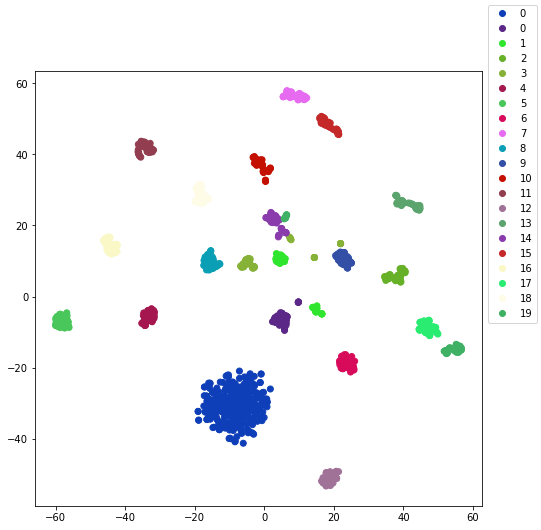

array([[-12.073008 , -29.900043 ],
       [ -7.1669264, -20.941431 ],
       [-13.813874 , -33.815826 ],
       ...,
       [ 56.49638  , -14.870165 ],
       [ 56.668415 , -14.471451 ],
       [ 56.65435  , -15.050051 ]], dtype=float32)

In [47]:
xs = []
ys = []
labels = []
count = 0
for ndx, anchor_class in enumerate(finetune_train_anchors):
    for anchor in anchor_class:
        xs.append(predictor.predict(anchor))
        ys.append(count)
    count += 1
    labels.append(ndx)

for ndx, anchor_class in enumerate(train_anchors):
    if ndx == 20:
        break
    for anchor in anchor_class:
        xs.append(predictor.predict(anchor))
        ys.append(count)
    count += 1
    labels.append(ndx)

analyzer = Analyzer(xs, ys, labels)
analyzer.plot(analyzer.tsne(2, n_jobs=-1))

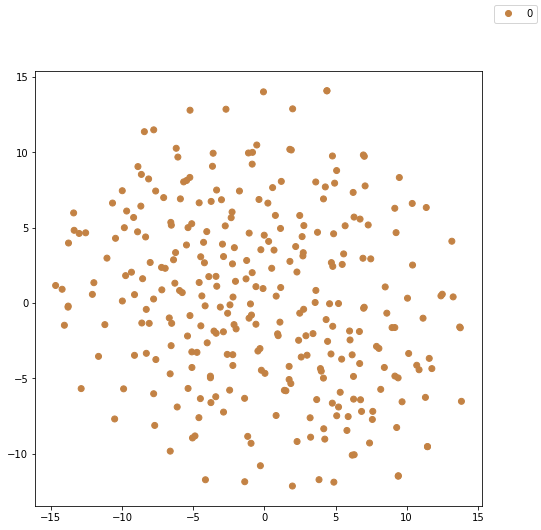

array([[ 2.91910553e+00, -2.17602205e+00],
       [-8.02337646e+00,  2.68965983e+00],
       [ 8.17507839e+00, -5.73541260e+00],
       [ 1.13167248e+01, -6.26823139e+00],
       [-5.36593723e+00,  5.00407410e+00],
       [ 6.69545269e+00, -4.02145004e+00],
       [ 9.28649545e-01, -2.04799390e+00],
       [ 3.24838972e+00, -8.91158867e+00],
       [ 2.45501995e-01,  6.63252258e+00],
       [ 7.29500008e+00,  5.18061829e+00],
       [ 7.02329063e+00,  9.73966026e+00],
       [ 2.40564704e+00, -2.47705030e+00],
       [-2.47516468e-01,  3.53695512e+00],
       [ 5.88775539e+00, -7.54368496e+00],
       [-1.13710966e-02,  4.50107384e+00],
       [-5.23823881e+00,  8.33740807e+00],
       [ 1.13387740e+00,  4.94903040e+00],
       [ 2.99760520e-01,  4.08917809e+00],
       [-2.13236618e+00, -1.43614125e+00],
       [-4.27298307e+00,  4.02748299e+00],
       [-2.09741548e-01, -4.46607399e+00],
       [-5.47473240e+00,  3.85143805e+00],
       [-1.98719954e+00, -1.72027802e+00],
       [-4.

In [48]:
xs = []
ys = []
labels = []
count = 0
for ndx, anchor_class in enumerate(finetune_train_anchors):
    for anchor in anchor_class:
        xs.append(predictor.predict(anchor))
        ys.append(count)
    count += 1
    labels.append(ndx)

analyzer = Analyzer(xs, ys, labels)
analyzer.plot(analyzer.tsne(2, n_jobs=-1))

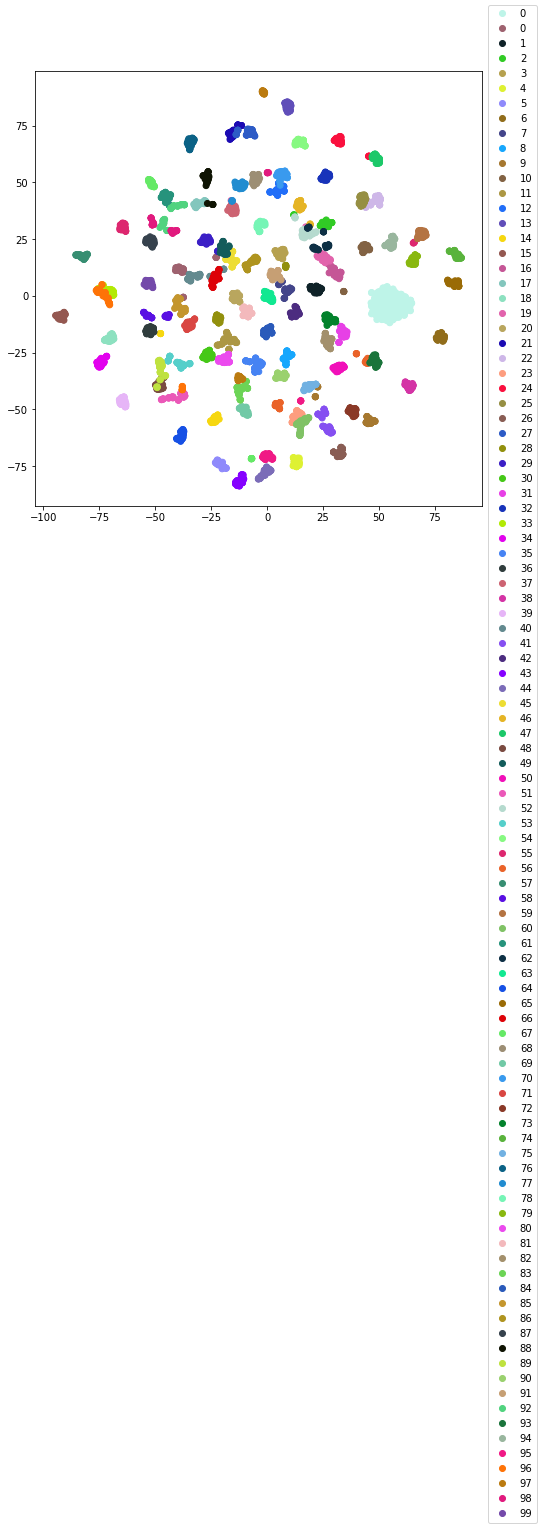

array([[ 57.66785  ,  -5.281871 ],
       [ 49.729637 ,  -0.6099426],
       [ 61.55205  ,  -4.592135 ],
       ...,
       [-53.597332 ,   4.3038325],
       [-54.013374 ,   4.682884 ],
       [-53.5829   ,   4.841387 ]], dtype=float32)

In [50]:
xs = []
ys = []
labels = []
count = 0
for ndx, anchor_class in enumerate(finetune_train_anchors):
    for anchor in anchor_class:
        xs.append(predictor.predict(anchor))
        ys.append(count)
    count += 1
    labels.append(ndx)

for ndx, anchor_class in enumerate(vali_anchors):
    for anchor in anchor_class:
        xs.append(predictor.predict(anchor))
        ys.append(count)
    count += 1
    labels.append(ndx)

analyzer = Analyzer(xs, ys, labels)
analyzer.plot(analyzer.tsne(2, n_jobs=-1))

In [24]:
x = predictor.predict_all(finetune_train_anchors[0])
y = predictor.predict_all(train_anchors[0])
(tf.reduce_mean(tf.norm(np.expand_dims(x, axis=-2) - x, axis=-1), axis=-1),
 tf.reduce_mean(tf.norm(np.expand_dims(y, axis=-2) - x, axis=-1), axis=-1))

(<tf.Tensor: shape=(300,), dtype=float32, numpy=
 array([0.15528163, 0.21907224, 0.22109452, 0.27726483, 0.17747025,
        0.25830412, 0.16874145, 0.21313754, 0.22317205, 0.4115596 ,
        0.23457265, 0.15531313, 0.15173832, 0.18575992, 0.1573287 ,
        0.1806296 , 0.16412018, 0.15359475, 0.146716  , 0.1536792 ,
        0.1664482 , 0.16457358, 0.15495498, 0.17578194, 0.16506177,
        0.17772293, 0.169589  , 0.18941776, 0.31893474, 0.16283536,
        0.17127067, 0.1950116 , 0.18518808, 0.25665918, 0.2585591 ,
        0.22752772, 0.16586594, 0.18751802, 0.18498917, 0.18035592,
        0.3594549 , 0.27120563, 0.16175649, 0.19841178, 0.18507063,
        0.16321197, 0.1600344 , 0.24748251, 0.16297086, 0.29044655,
        0.19821012, 0.23324613, 0.16238701, 0.22019458, 0.19384618,
        0.19346298, 0.1653583 , 0.2730835 , 0.23094195, 0.19679217,
        0.17113858, 0.2611282 , 0.16634555, 0.19092235, 0.22228503,
        0.20785041, 0.1627188 , 0.15477712, 0.27949843, 0.15980983,

In [28]:
x.std(axis=0)

array([0.0130352 , 0.01265028, 0.01733283, 0.0126568 , 0.0112622 ,
       0.01147484, 0.01164816, 0.01305964, 0.01207198, 0.01240061,
       0.01128127, 0.00936231, 0.01384779, 0.0164249 , 0.01291086,
       0.01133553, 0.01917986, 0.01738548, 0.01211839, 0.01557206,
       0.01045355, 0.0092916 , 0.01584171, 0.01227358, 0.01196989,
       0.01224303, 0.01392185, 0.01597326, 0.0185559 , 0.01525345,
       0.01244663, 0.01469904, 0.01709085, 0.01467155, 0.01340278,
       0.01497811, 0.01394091, 0.01525753, 0.01150072, 0.01386071,
       0.01243435, 0.01534927, 0.01450659, 0.01405518, 0.00986717,
       0.01668305, 0.00929645, 0.01164661, 0.0198894 , 0.01439238,
       0.01433529, 0.01280553, 0.01459636, 0.01062925, 0.01466392,
       0.01348676, 0.01546178, 0.01436653, 0.01181833, 0.01470618,
       0.01027185, 0.01388743, 0.01432543, 0.01583738, 0.01819582,
       0.01298114, 0.01005225, 0.01549922, 0.01183965, 0.01697497,
       0.01583968, 0.01379207, 0.01289942, 0.01615327, 0.01254

In [58]:
(tf.reduce_mean(tf.norm(x - x[0], axis=-1), axis=-1),
 tf.reduce_mean(tf.norm(y - x[0], axis=-1), axis=-1))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.15528163>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.7911307>)

In [35]:
np.vstack([x[:50], y]).std(axis=0)

array([0.09912852, 0.10937338, 0.14690962, 0.02081028, 0.17057383,
       0.08798157, 0.03482689, 0.05031733, 0.0974283 , 0.0539191 ,
       0.08237098, 0.02556111, 0.11849643, 0.11560617, 0.08657283,
       0.02136679, 0.02472418, 0.05400122, 0.06311009, 0.05361278,
       0.05281899, 0.03414728, 0.02851716, 0.04655919, 0.17597714,
       0.04485776, 0.02660992, 0.03648687, 0.08015198, 0.07156558,
       0.08183597, 0.0921364 , 0.09860111, 0.1272211 , 0.08158036,
       0.09343781, 0.05281677, 0.07474243, 0.03215644, 0.07084153,
       0.04700389, 0.13361013, 0.10383555, 0.05788915, 0.05882487,
       0.05190179, 0.01772996, 0.02975049, 0.13697137, 0.11235134,
       0.05847498, 0.08904757, 0.09787959, 0.08382636, 0.05842729,
       0.11427787, 0.06897619, 0.09435453, 0.02200817, 0.04310862,
       0.05282253, 0.02011072, 0.08882554, 0.08998717, 0.17693314,
       0.10323833, 0.0394597 , 0.07193474, 0.07105272, 0.06969061,
       0.06755059, 0.15044172, 0.07652251, 0.15413481, 0.11832

In [75]:
np.linalg.norm(np.stack([x[:50], y]) - x[0], axis=-1).mean(axis=-1)

array([0.14008561, 1.7911307 ], dtype=float32)

## Live Test

In [53]:
path = '20210819_094605_606706'
predictor = Predictor(path)

In [53]:
def live_comparison(predictor, length, rate):
    p = pyaudio.PyAudio()
    patype = pyaudio.paInt16
    stream = p.open(format=patype,
                    channels=1,
                    rate=rate,
                    input=True,
                    frames_per_buffer=4096)
    unique_recordings = []
    frames = []
    while True:
        frames = np.append(frames, np.frombuffer(stream.read(4096), dtype='int16') / np.iinfo('int16').max)
        if len(frames) > rate * length:
            x = frames[-rate * length:]
            x = audio.vad_trim_all(x, rate, .03, 1)
            x = audio.set_duration(x, rate, 3)
            x = predictor.predict(x)
            unique_recordings.append(x)
            print(np.linalg.norm(np.array(unique_recordings) - x, axis=-1))
            frames = []
    stream.stop_stream()
    stream.close()
    p.terminate()

In [54]:
live_comparison(predictor, length, sample_rate)

[0.]
[0.21109284 0.        ]
[0.35025597 0.2750733  0.        ]
[0.09095074 0.1856679  0.3286541  0.        ]
[0.33600375 0.2488216  0.09859336 0.30595717 0.        ]
[0.34444156 0.2498383  0.15226784 0.31594807 0.13180384 0.        ]
[0.26972124 0.211155   0.23151547 0.25548065 0.18803279 0.19626991
 0.        ]
[0.6259495  0.49738595 0.5215405  0.6009338  0.49643227 0.45294213
 0.48961043 0.        ]
[0.3925366  0.27584246 0.32438016 0.38124686 0.29568624 0.24033782
 0.26928616 0.32291666 0.        ]
[0.15674827 0.21872306 0.29740483 0.17292899 0.2832978  0.2825524
 0.22803357 0.58335906 0.35004157 0.        ]
[1.8932238 1.8992106 1.8757032 1.9013242 1.874851  1.8675575 1.8715237
 1.8142625 1.860294  1.8553405 0.       ]
[1.8938204  1.8967338  1.869918   1.901319   1.8697081  1.8631095
 1.8698916  1.8060142  1.8532057  1.8549495  0.14134718 0.        ]
[0.63930684 0.6437438  0.64513516 0.6642549  0.6482819  0.6565629
 0.62700725 0.86636996 0.6497544  0.6450511  1.7968775  1.796181
 0

[0.19847772 0.32249814 0.40657362 0.22522241 0.40155017 0.40144455
 0.33554325 0.69962156 0.48400223 0.26958975 1.8873686  1.8935078
 0.6704369  0.5683835  0.34433532 0.6424969  1.1766858  1.8630224
 1.8639191  1.8634343  0.44419968 0.3008892  1.8841518  1.8900763
 0.7382853  0.49484396 0.9632864  1.9202266  1.662113   0.68357515
 0.54570323 0.49478936 0.3468442  1.4785947  1.7898244  1.2997619
 1.0460234  0.19646028 0.20333499 0.        ]
[0.783778   0.69727165 0.5142394  0.7679733  0.56206816 0.5597399
 0.6924736  0.67507404 0.653996   0.73700035 1.7730395  1.7622613
 0.92457235 0.97250867 0.7217088  0.4386935  0.91488326 1.7104936
 1.7142793  1.7172252  1.0692271  0.8546098  1.8048335  1.7740772
 0.80391973 0.7262137  0.971881   1.8181618  1.6118802  0.89926
 0.9253492  0.8126082  0.90187716 1.5900674  1.7043992  1.4938658
 1.1239331  0.79410523 0.7558018  0.8030074  0.        ]
[0.6268025  0.51798236 0.48771447 0.6109376  0.43723443 0.42561302
 0.42158914 0.42229554 0.39947566 0.58

KeyboardInterrupt: 

In [96]:
import time

In [139]:
def live_recognition(predictor, length, rate, interval, percentile=10, max_individual_recordings=100):
    if interval <= 0:
        interval = .01
    p = pyaudio.PyAudio()
    patype = pyaudio.paInt16
    chunk = int(interval * sample_rate // 2)
    stream = p.open(format=patype,
                    channels=1,
                    rate=rate,
                    input=True,
                    frames_per_buffer=chunk)
    recordings = []
    frames = []
    fr = interval / 2
    while True:
        if fr / 2 > interval:
            interval = fr * 2
            chunk = int(fr * sample_rate)
        frames = np.append(frames, np.frombuffer(stream.read(chunk), dtype='int16') / np.iinfo('int16').max)
        if len(frames) > rate * length:
            st = time.time()
            x = frames[-rate * length:]
            x = audio.vad_trim_all(x, rate, .03, 1)
            x = audio.set_duration(x, rate, 3)
            x = predictor.predict(x)
            
            if len(recordings) == 0:
                recordings.append([x])
                print(0)
            else:
                diff = [
                    np.percentile(np.linalg.norm(np.array(individual_recordings) - x, axis=-1), percentile, axis=-1)
                    for individual_recordings in recordings
                ]
                #print(diff)
                min_ndx = np.argmin(diff)
                min_diff = diff[min_ndx]
                if min_diff < .8:
                    recordings[min_ndx].append(x)
                    if max_individual_recordings < len(recordings[min_ndx]):
                        del recordings[min_ndx][0]
                    print(f'{min_ndx}: {min_diff}')
                elif min_diff > 1.2:
                    recordings.append([x])
                    print(f'New: {len(recordings) - 1}')
                else:
                    print(f'Unclear: {min_diff}')
            frames = frames[int(sample_rate * interval):]
            fr = fr * .1 + (time.time()-st) * .9
    stream.stop_stream()
    stream.close()
    p.terminate()

In [147]:
live_recognition(predictor, length, sample_rate, 1, 50)

0
0: 0.3859616219997406
0: 0.39008545875549316
0: 0.5819342732429504
0: 0.5163835287094116
0: 0.5017656087875366
0: 0.4359574317932129
0: 0.33780303597450256
0: 0.48310069739818573
0: 0.45546868443489075
0: 0.4888274371623993
0: 0.4016497731208801
0: 0.47978223860263824
0: 0.3409970700740814
0: 0.31231676042079926
0: 0.3297954201698303
0: 0.3813764452934265
0: 0.407272070646286
0: 0.38887909054756165
0: 0.43549424409866333
0: 0.45686928927898407
0: 0.41471800208091736
0: 0.4523685872554779
0: 0.41180816292762756
0: 0.3071620762348175
0: 0.365298330783844
0: 0.3692651093006134
0: 0.3730725049972534
0: 0.3577447384595871
0: 0.3308296501636505
0: 0.35854797065258026
Unclear: 0.8524372577667236
0: 0.3755187690258026
0: 0.7106708884239197
0: 0.635956346988678
0: 0.4419492185115814
0: 0.3465554416179657
0: 0.37280331552028656
0: 0.46114104986190796
0: 0.5109970271587372
0: 0.5724343061447144
0: 0.385910764336586
0: 0.44186487793922424
0: 0.38220834732055664
0: 0.3141521215438843
0: 0.4827601

0: 0.5186799764633179
0: 0.5266749560832977
0: 0.43143726885318756
0: 0.08499123156070709
0: 0.0906786173582077
0: 0.07820780202746391
0: 0.49352486431598663
0: 0.46702390909194946
0: 0.45579755306243896
0: 0.4253084808588028
0: 0.10268609970808029
0: 0.10208207368850708
0: 0.08430740982294083
0: 0.08325955644249916
0: 0.08355716243386269
0: 0.09750275686383247
0: 0.07222210988402367
0: 0.07119080796837807
Unclear: 0.836485892534256
0: 0.7850103676319122
0: 0.7077224850654602
0: 0.5070070326328278
0: 0.3860573172569275
0: 0.3718435913324356
0: 0.45468026399612427
0: 0.5078504681587219
0: 0.5182711482048035
0: 0.6226867437362671
0: 0.6112574338912964
0: 0.5153568089008331
0: 0.6169925332069397
0: 0.570788562297821
0: 0.4584001302719116
0: 0.5337325036525726
0: 0.21433411538600922
0: 0.21495960652828217
0: 0.2000264674425125
0: 0.20490626990795135
0: 0.4780557155609131
0: 0.4515988975763321
0: 0.5991224646568298
0: 0.6274597644805908
0: 0.49438178539276123
0: 0.6098460853099823
0: 0.5614

KeyboardInterrupt: 